In [36]:
import pandas as pd
import numpy as np
import plotly.express as px
import scipy.stats as stats
from IPython.display import Image

In [7]:
df1 = pd.read_csv('15_Data.csv')

In [4]:
# XGboosting Model
!pip install xgboost

  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/03/e6/4aef6799badc2693548559bad5b56d56cfe89eada337c815fdfe92175250/xgboost-2.0.3-py3-none-macosx_12_0_arm64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 11.4 MB/s eta 0:00:0000:0100:01


In [5]:
from xgboost import XGBClassifier

In [8]:
df1.columns

Index(['Column 1', '환자ID', '수술기법', '수술시간', '수술실패여부', '신장', '연령', '재발여부', '체중',
       '헤모글로빈수치', '환자통증정도', '통증기간(월)', '혈액형', '수술일', '입원일', '퇴원일'],
      dtype='object')

In [10]:
df1['재발여부'].isnull().sum()

0

In [12]:
Y = df1['재발여부']
X = df1[['신장', '연령', '체중','헤모글로빈수치', '환자통증정도', '통증기간(월)', '혈액형']]

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from imblearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from imblearn.combine import SMOTETomek
from sklearn.model_selection import GridSearchCV

In [23]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,random_state=1234)

In [24]:
numeric_list = X.describe().columns
category_list = X.describe(include='object').columns

In [25]:
numeric_pipe = make_pipeline(SimpleImputer(strategy='median')) # 트리 기반 -> 스케일링 필요없음
category_pipe = make_pipeline(SimpleImputer(strategy='most_frequent'),
                             OneHotEncoder())

In [26]:
prepropipe = make_column_transformer((numeric_pipe, numeric_list),
                                     (category_pipe, category_list))
model_pipe1 = make_pipeline(prepropipe, SMOTETomek(), XGBClassifier())

In [28]:
# n_estimators : 몇 번 학습을 수행할 것인지? (트리 개수)
hyperparameter = {'xgbclassifier__n_estimators':[100,200,500],
                 'xgbclassifier__learning_rate':[0.01, 0.1, 1, 1.5],
                 'xgbclassifier__max_depth':[5]}
grid_model = GridSearchCV(model_pipe1, param_grid=hyperparameter,
                          cv=3, n_jobs=-1, scoring='f1')
grid_model.fit(X_train, Y_train)
best_model = grid_model.best_estimator_

In [31]:
from sklearn.metrics import classification_report

def eval_classification(model):
    Y_train_pred = model.predict(X_train)
    Y_test_pred = model.predict(X_test)
    print('학습능력')
    print(classification_report(Y_train, Y_train_pred))
    print('일반화능력')
    print(classification_report(Y_test, Y_test_pred))

In [32]:
eval_classification(best_model)

학습능력
              precision    recall  f1-score   support

           0       0.90      0.99      0.94      1247
           1       0.73      0.23      0.35       173

    accuracy                           0.90      1420
   macro avg       0.81      0.61      0.65      1420
weighted avg       0.88      0.90      0.87      1420

일반화능력
              precision    recall  f1-score   support

           0       0.90      0.97      0.93       420
           1       0.42      0.15      0.22        54

    accuracy                           0.88       474
   macro avg       0.66      0.56      0.58       474
weighted avg       0.84      0.88      0.85       474



----------

### Stacking Model

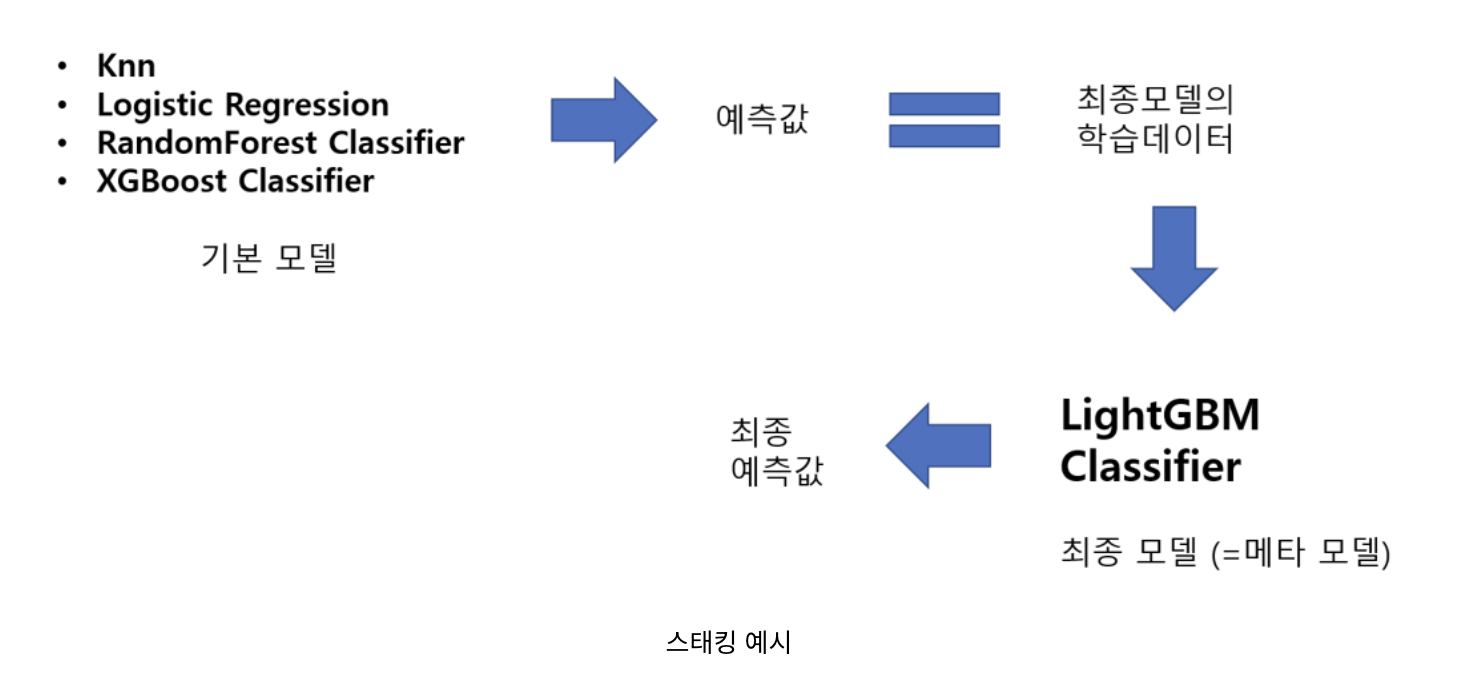

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [38]:
model_pipe2 = make_pipeline(prepropipe, SMOTETomek(), LogisticRegression())
model_pipe3 = make_pipeline(prepropipe, SMOTETomek(), RandomForestClassifier())

In [41]:
model_pipe2.fit(X_train, Y_train)

/Users/sinhyelim/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  Index(['신장', '연령', '체중', '헤모글로빈수치', '환자통증정도', '통증기간(월)'], dtype='object')),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder())]),
                                                  Index(['혈액형'], dtype='object'))])),
                ('smotetomek', SMOTETomek()),
                ('logisticregression', LogisticRegression())])

In [42]:
model_pipe3.fit(X_train, Y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  Index(['신장', '연령', '체중', '헤모글로빈수치', '환자통증정도', '통증기간(월)'], dtype='object')),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder())]),
                                                  Index(['혈액형'], dtype='object'))])),
                ('smotetomek', SMOTETomek()),
                ('randomforestclassifier', RandomForestClassifier())])

In [47]:
# 학습 성능 확인

df_meta_train = pd.DataFrame()
df_meta_train['XGBpred'] = pd.DataFrame(best_model.predict_proba(X_train))[1]
# 왼쪽은 정상일 확률, 오른쪽은 재발할 확률
df_meta_train['LRpred'] = pd.DataFrame(model_pipe2.predict_proba(X_train))[1]
df_meta_train['RFpred'] = pd.DataFrame(model_pipe3.predict_proba(X_train))[1]

In [49]:
df_meta_train.head(2)

,XGBpred,LRpred,RFpred
0,0.426617,0.627399,0.74
1,0.383685,0.258545,0.08


In [50]:
# 일반화 성능 확인

df_meta_test = pd.DataFrame()
df_meta_test['XGBpred'] = pd.DataFrame(best_model.predict_proba(X_test))[1]
# 왼쪽은 정상일 확률, 오른쪽은 재발할 확률
df_meta_test['LRpred'] = pd.DataFrame(model_pipe2.predict_proba(X_test))[1]
df_meta_test['RFpred'] = pd.DataFrame(model_pipe3.predict_proba(X_test))[1]

In [52]:
df_meta_test.head(2)

,XGBpred,LRpred,RFpred
0,0.215953,0.161828,0.06
1,0.401122,0.537616,0.14


In [57]:
# Stacking Model에 사용될 Meta Model 선정
from sklearn.ensemble import GradientBoostingClassifier

In [58]:
model = GradientBoostingClassifier()

In [62]:
hyperparameter={'loss':['log_loss','exponential'],
               'n_estimators':[50,100,200],
               'n_iter_no_change':[5],
               'max_depth':[3,5,7]}
# 'n_iter_no_change' -> (할당한 수만큼 복원추출해보고) 성능이 개선이 없다면 조기종료
meta_grid_model = GridSearchCV(model, param_grid=hyperparameter,
                               cv=3, n_jobs=-1, scoring='f1')
# cv= cross validation
meta_grid_model.fit(df_meta_train, Y_train)
best_meta_model = meta_grid_model.best_estimator_

In [63]:
Y_train_meta_pred = best_meta_model.predict(df_meta_train)
Y_test_meta_pred = best_meta_model.predict(df_meta_test)

In [64]:
print(classification_report(Y_train, Y_train_meta_pred))
# 오버피팅 발생

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1247
           1       1.00      0.99      1.00       173

    accuracy                           1.00      1420
   macro avg       1.00      1.00      1.00      1420
weighted avg       1.00      1.00      1.00      1420



In [65]:
print(classification_report(Y_test, Y_test_meta_pred))

              precision    recall  f1-score   support

           0       0.90      0.99      0.94       420
           1       0.50      0.11      0.18        54

    accuracy                           0.89       474
   macro avg       0.70      0.55      0.56       474
weighted avg       0.85      0.89      0.85       474



- loss : 최적화 함수 선택
    - logg_lost : 로지스틱 회귀에서 사용되는 로그 손실함수를 이용해 최적화
    - exponential : Exp 함수를 이용해 손실함수를 계산하여 최적화 (Ada boosting)
    
- learning_rate : 학습율 (각 트리에 기여도를 축소하는 학습율)
- n_estimators : 수행할 학습의 개수 (트리의 개수 지정)
- subsample : 복원 추출에 사용되는 데이터의 비율
- ...

In [67]:
import pickle
pickle.dump(best_model, open('model_best.sav','wb'))